# 숙박 시설↔관광지 거리

- 관광지 주변의 숙박 시설을 보여주기 위해 숙박 시설과 관광명소 사이의 거리를 Pandas.Dataframe 형태로 저장

In [ ]:
import pandas as pd

accom_poi = pd.read_excel('./data/220124/_종합_숙박.xlsx', index_col=False)
jeju_poi = pd.read_excel('./data/220123/_종합_POI_content.xlsx', index_col=False)

In [ ]:
accom_poi.head(1)

,id,place_name,address_name,place_url,x,y,keyword,rating,grade
0,907075,월정힐펜션,제주특별자치도 제주시 구좌읍 월정리 699-3,http://place.map.kakao.com/907075,126.791441,33.557925,펜션,5.0,펜션


In [ ]:
jeju_poi.head(1)

,idx,keyword,address_name,category_group_name,category_name,id,place_name,x,y,rating,kind,content
0,0,테마파크,제주특별자치도 제주시 연동 1320,관광명소,"문화,예술 > 문화시설 > 박물관",26388484,수목원테마파크 아이스뮤지엄,126.488398,33.470777,1.0,제주시,테마파크 관광명소


## 1. 위도, 경도를 이용한 직선거리 함수

- 위도, 경도 계산
    - 우리나라 기준 1도 = 88.8km, 1분 = 1.48km, 1초 = 25m
    - 구글의 좌표는 `도` 기준
    - 위도 차이 : ((a.lat - b.lat) * 88.8) km
    - 경도 차이 : ((a.lng - b.lng) * 88.8) km
    - 거리 차이 : (위도 차이 ** 2 + 경도 차이 ** 2) ** (1/2) km

**미리 계산을 진행해둘 계획이였지만, 계산이 오래 거릴지 않아 함수만 유지**

In [ ]:
# pos1 : (x좌표, y좌표)
# pos2 : (x좌표, y좌표)
def cal_dist(pos1, pos2):
    return (((pos1[1] - pos2[1])*88.8)**2 +((pos1[0] - pos2[0])*88.8)**2)**(1/2)

## 2. 숙박 시설↔관광지 거리

- **계산이 예상보다 빨라서 필요한 경우 계산하여 사용하는 것으로 결정**

In [ ]:
from tqdm.notebook import tqdm

for idx, row in tqdm(jeju_poi.iterrows()):
    accom_poi[str(row['id'])] = cal_dist((accom_poi['x'], accom_poi['y']), (row['x'], row['y']))

0it [00:00, ?it/s]

C:\Users\ISANGH~1\AppData\Local\Temp/ipykernel_31216/1861455450.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  accom_poi[str(row['id'])] = cal_dist((accom_poi['x'], accom_poi['y']), (row['x'], row['y']))


In [ ]:
accom_poi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004 entries, 0 to 3003
Columns: 3017 entries, id to 25548687
dtypes: float64(3011), int64(1), object(5)
memory usage: 69.1+ MB


In [ ]:
accom_poi.head(1)

,id,place_name,address_name,place_url,x,y,keyword,rating,grade,26388484,...,1643413816,13723872,27441187,742400088,1218626372,18951459,75702988,1421354324,1620380468,25548687
0,907075,월정힐펜션,제주특별자치도 제주시 구좌읍 월정리 699-3,http://place.map.kakao.com/907075,126.791441,33.557925,펜션,5.0,펜션,28.00091,...,25.889372,27.345294,31.238286,31.180461,31.241943,31.227433,30.986696,31.23961,30.542049,29.131936


# 주변 관광지 개수

- 5KM(임시) 내의 주변 관광지 개수 : 관광명소, 음식점, 카페

In [ ]:
import pandas as pd

jeju_poi = pd.read_excel('./data/220123/_종합_POI_content.xlsx', index_col=False)

In [ ]:
jeju_poi.head(1)

,idx,keyword,address_name,category_group_name,category_name,id,place_name,x,y,rating,kind,content
0,0,테마파크,제주특별자치도 제주시 연동 1320,관광명소,"문화,예술 > 문화시설 > 박물관",26388484,수목원테마파크 아이스뮤지엄,126.488398,33.470777,1.0,제주시,테마파크 관광명소


## 1. 주변 광광지 개수 계산 함수

In [ ]:
def adjacent_poi_count(poi1, poi2):
    dist = cal_dist(poi1, poi2)
    return len(dist[dist <= 5])

## 2. 주변 관광지 개수

- adjacent_tour : 주변 관광명소 수 
- adjacent_rest : 주변 음식점 수
- adjacent_cafe : 주변 카페 수

In [ ]:
from tqdm.notebook import tqdm

jeju_poi['adjacent_tour'] = 0
jeju_poi['adjacent_rest'] = 0
jeju_poi['adjacent_cafe'] = 0
for idx, row in tqdm(jeju_poi.iterrows()):
    temp_tour = jeju_poi.drop(idx, axis=0).query('category_group_name == "관광명소"')
    temp_rest = jeju_poi.drop(idx, axis=0).query('category_group_name == "음식점"')
    temp_cafe = jeju_poi.drop(idx, axis=0).query('category_group_name == "카페"')

    jeju_poi.loc[idx, 'adjacent_tour'] = adjacent_poi_count((row['x'], row['y']), (temp_tour['x'], temp_tour['y']))
    jeju_poi.loc[idx, 'adjacent_rest'] = adjacent_poi_count((row['x'], row['y']), (temp_rest['x'], temp_rest['y']))
    jeju_poi.loc[idx, 'adjacent_cafe'] = adjacent_poi_count((row['x'], row['y']), (temp_cafe['x'], temp_cafe['y']))

    del temp_tour
    del temp_rest
    del temp_cafe

0it [00:00, ?it/s]

In [ ]:
jeju_poi[['adjacent_tour', 'adjacent_rest', 'adjacent_cafe']].head(5)

,adjacent_tour,adjacent_rest,adjacent_cafe
0,29,268,138
1,17,168,45
2,22,43,16
3,19,21,6
4,19,131,56


In [ ]:
jeju_poi.to_excel('./data/220124/_종합_POI_주변관광지.xlsx', index=False)

## 3. 데이터 확인

In [ ]:
import pandas as pd

jeju_poi_adjacent = pd.read_excel('./data/220124/_종합_POI_주변관광지.xlsx', index_col=False)

In [ ]:
jeju_poi_adjacent.head(3)

,idx,keyword,address_name,category_group_name,category_name,id,place_name,x,y,rating,kind,content,adjacent_tour,adjacent_rest,adjacent_cafe
0,0,테마파크,제주특별자치도 제주시 연동 1320,관광명소,"문화,예술 > 문화시설 > 박물관",26388484,수목원테마파크 아이스뮤지엄,126.488398,33.470777,1.0,제주시,테마파크 관광명소,29,268,138
1,1,"테마파크,가볼만한 곳",제주특별자치도 제주시 애월읍 신엄리 2880-12,관광명소,"여행 > 관광,명소 > 테마파크",1129394481,고스트타운,126.356936,33.476195,3.4,제주시,테마파크 가볼만한곳 관광명소,17,168,45
2,2,"테마파크,가볼만한 곳",제주특별자치도 제주시 애월읍 유수암리 1083,관광명소,"여행 > 관광,명소 > 테마파크",891104398,제주불빛정원,126.409179,33.422294,4.1,제주시,테마파크 가볼만한곳 관광명소,22,43,16


- 인접 관광지의 통계량 확인

In [ ]:
jeju_poi_adjacent[['adjacent_tour', 'adjacent_rest', 'adjacent_cafe']].describe()

,adjacent_tour,adjacent_rest,adjacent_cafe
count,3008.000000,3008.000000,3008.000000
mean,21.706117,155.068484,64.712101
std,6.499756,109.871119,49.360010
min,0.000000,0.000000,0.000000
25%,18.000000,68.750000,31.000000
50%,21.000000,126.000000,45.500000
75%,27.000000,212.000000,90.000000
max,42.000000,389.000000,179.000000


- 인접 관광지의 히스토그램 확인
  - `adjacent_tour`는 분포가 정규분포에 가깝다.
  - `adjacent_rest`, `adjacent_cafe`는 불균형이 존재한다.

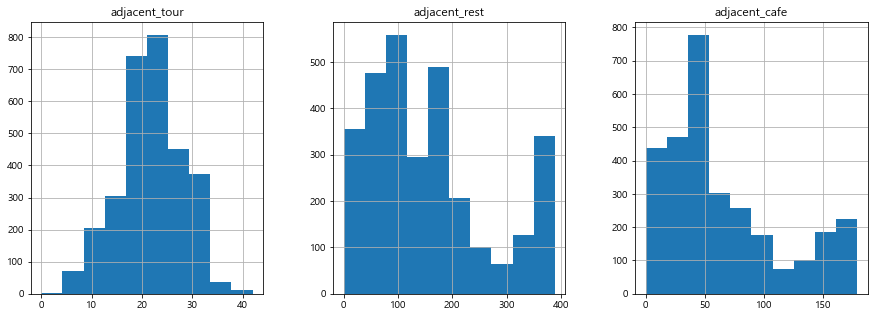

In [ ]:
jeju_poi_adjacent[['adjacent_tour', 'adjacent_rest', 'adjacent_cafe']].hist(layout=(1, 3), figsize=(15, 5));